<a href="https://colab.research.google.com/github/zxcej/COMP691_LABS/blob/main/Copy_of_COMP691_GenerativeQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 In this Question we will experiment with a few publicly available generative models

# Warm-up Face interpolation (there is no question here and you can skip this section if you want)

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

c:\Users\x_zhu202\Documents\GitHub\COMP691_LABS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to C:\Users\x_zhu202/.cache\torch\hub\hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to C:\Users\x_zhu202/.cache\torch\hub\checkpoints\celebaHQ16_december_s7_i96000-9c72988c.pth
100%|██████████| 264M/264M [00:23<00:00, 11.8MB/s] 


Average network found !


In [3]:

print(model.netG)

DataParallel(
  (module): GNet(
    (scaleLayers): ModuleList(
      (0): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): ModuleList(
        (0): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): EqualizedConv2d(
          (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (3): ModuleList(
        (0): EqualizedConv2d(
          (module): Con

We will visualize some randomly generated faces. Run this cell a few times to generate new faces

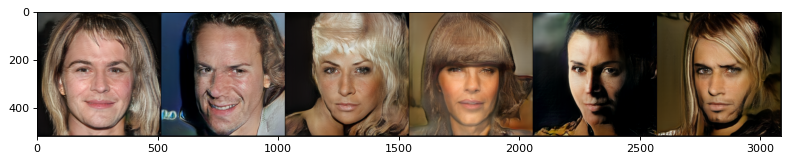

In [4]:
num_images = 6
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.netG(noise).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


In [5]:
print(noise.shape)
print(generated_images.shape)

torch.Size([6, 512])
torch.Size([6, 3, 512, 512])


Here we find two random faces images and their noise and writea function that will interpolate between two randomly generated faces. It will take a noise vector of size 2x512. Let's denote noise_1 and noise_2 the first and 2nd row. As above create 8 intermediate values that interpolate between them. 

e.g. if we had just one intermediate value we would end up with  noise_1, (noise_1+noise_2)/2, noise_2

we pass these through the generator (e.g. by putting them in a 8x512 noise tensor) and visualize the interpolation.

Note: again there is nothing to do here it is just an example to help you understand the next part

torch.Size([10, 512])
torch.Size([3, 1030, 4114])


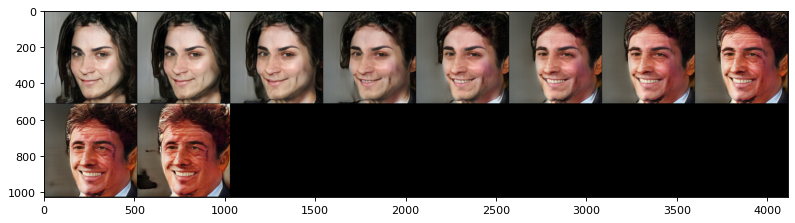

In [6]:
num_images = 2
noise, _ = model.buildNoiseData(num_images)
alpha = [0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]

noises = [noise[0]*a+noise[1]*(1.0-a) for a in alpha]
noises = torch.vstack(noises)
print(noises.shape)
with torch.no_grad():
    generated_images = model.netG(noises).detach()

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(12, 6), dpi=80)

plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
print(grid.shape)

# Big-GAN interpolations (25 points)

2. We will now experiment with the bigGAN model trained on natural images. You can find the implementation and further documentation here https://github.com/huggingface/pytorch-pretrained-BigGAN. Run the cells below to download the model and generate some random images.

In [7]:
# !pip install pytorch-pretrained-biggan
# !pip install libsixel-python
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\x_zhu202\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
import matplotlib.pyplot as plt
import torchvision


# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256')

# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['soap bubble', 'coffee', 'mushroom','fox','dog','lion'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=6)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

100%|██████████| 715/715 [00:00<00:00, 742676.41B/s]


We visualize the generated images

torch.Size([6, 128])
torch.Size([6, 1000])


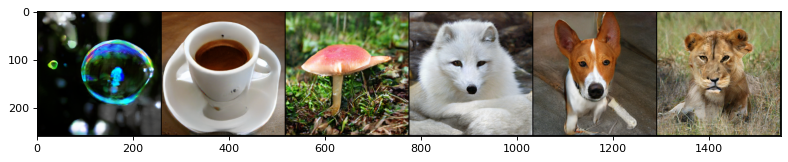

In [10]:
output.shape
print(noise_vector.shape)
print(class_vector.shape)
plt.figure(figsize=(12, 6), dpi=80)
grid = torchvision.utils.make_grid(output.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

Let's experiment with interpolating between different images in this model as we did in the face images. Note the BigGAN takes both a class vector and a random noise. 
(a) Sample two random images from the same category such as "dog" and interpolate between them with 8 intermediate steps and using the same class vector
(b) Sample two random images from two diff classes (e.g. "dog" and "mushroom") and interpolate between them. For the class conditionin variable you may interpolate between these as well for best results.

Feel free to try other combinations and categories.

Example of what your answer shoudl look like are below. however you should show it for a different images then the ones below (And different ones than your classmates :))

Same class interpolation of lion


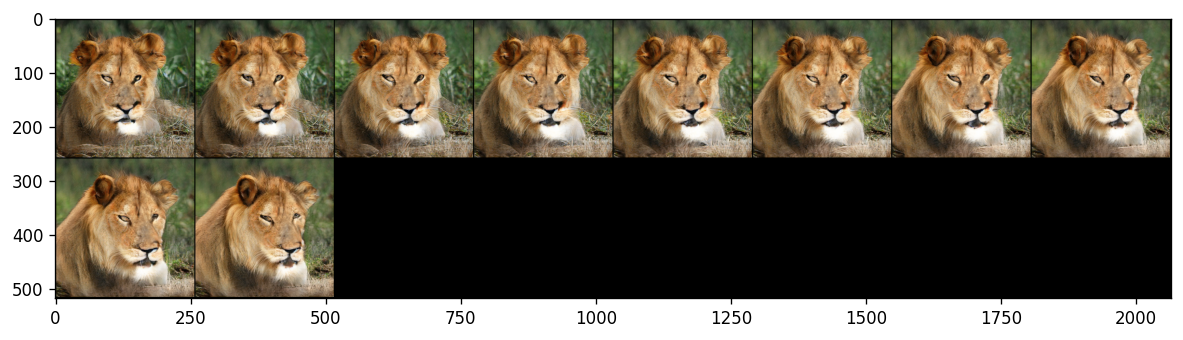

Diff class interpolation of soap bubble and coffee


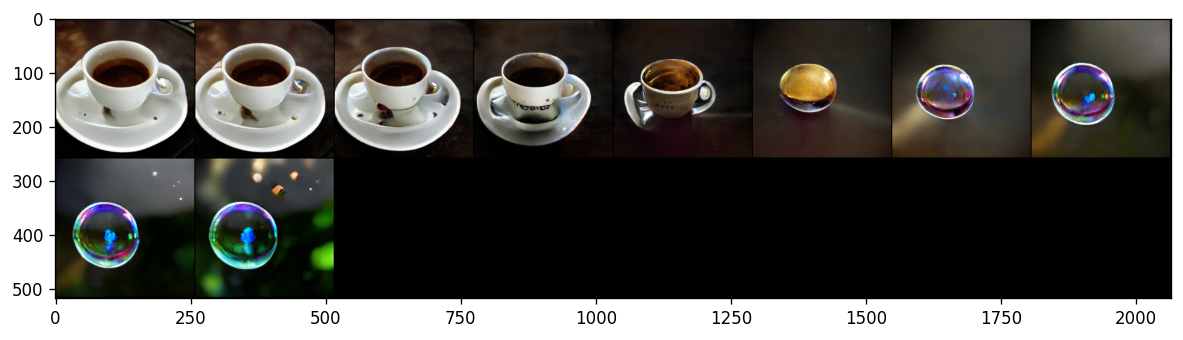

In [32]:
import numpy as np


def interpolate_image(class_name1, class_name2, noise1, noise2, num_interpolation =8):
    alpha_values = np.linspace(0, 1, num_interpolation+2)
    interpolated_noises = [noise1 * alpha + noise2 * (1 - alpha) for alpha in alpha_values]
    class1 = one_hot_from_names([class_name1])[0]
    class2 = one_hot_from_names([class_name2])[0]
    interpolated_classes = [class1 * alpha + class2 * (1 - alpha) for alpha in alpha_values]

    noise_tensor = torch.from_numpy(np.vstack(interpolated_noises)).to('cuda')
    class_tensor = torch.from_numpy(np.vstack(interpolated_classes)).to('cuda')
    
    # Generate an image
    with torch.no_grad():
        output = model(noise_tensor, class_tensor, truncation)
    
    # If you have a GPU put back on CPU
    return output.to('cpu')

def display_images(images):
    grid = torchvision.utils.make_grid(images.clamp(min=-1, max=1), scale_each=True, normalize=True)
    plt.figure(figsize=(12, 6), dpi=120)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

noise1_same_class = truncated_noise_sample(truncation=truncation, batch_size=1)
noise2_same_class = truncated_noise_sample(truncation=truncation, batch_size=1)
generated_images_same_class = interpolate_image('lion', 'lion', noise1_same_class, noise2_same_class)

noise1_diff_class = truncated_noise_sample(truncation=truncation, batch_size=1)
noise2_diff_class = truncated_noise_sample(truncation=truncation, batch_size=1)
generated_images_diff_class = interpolate_image('soap bubble', 'coffee', noise1_diff_class, noise2_diff_class)

print(f"Same class interpolation of lion")
display_images(generated_images_same_class)
print(f"Diff class interpolation of soap bubble and coffee")
display_images(generated_images_diff_class)


torch.Size([10, 128])
torch.Size([10, 1000])


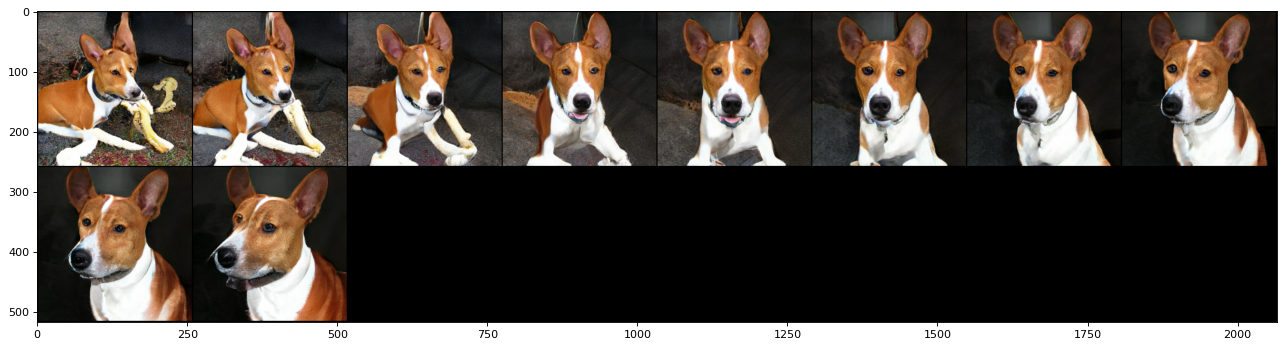

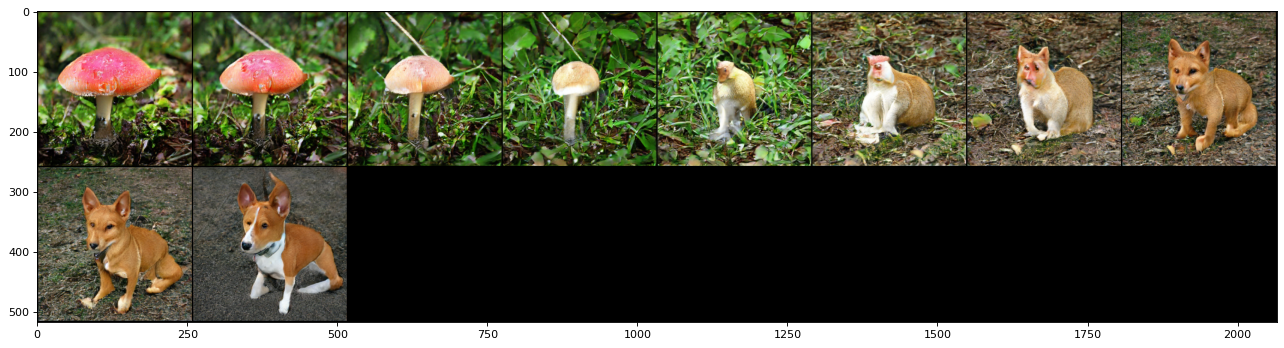

# Extra Credit Stable Diffusion Interpolations (8 points)

Experiment with the stable diffusion model (example notebook here https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb). For two prompts of your choosing sample the images and also create interpolations between two images of your choice (as in the above questions) they can be images of the same and different prompts. 

In [36]:
from diffusers import StableDiffusionPipeline
from torchvision.utils import make_grid
from IPython.display import Image, display

prompts = ['sunset', 'ocean']

def diffused_images(prompt, num_images=2):
    pipeline = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-1-base', torch_dtype=torch.float16)
    pipeline.to('cuda')
    multiple_prompts = [prompt] * num_images
    images = pipeline(multiple_prompts).images
    return images

def interpolate_images(image1, image2, num_interpolation=8):
    alpha_values = np.linspace(0, 1, num_interpolation+2)
    interpolated_images = [image1 * alpha + image2 * (1 - alpha) for alpha in alpha_values]
    return torch.stack(interpolated_images)

def display_images(images,title):
    grid = make_grid(images.clamp(min=-1, max=1), nrow=len(images), padding=2, pad_value=0, scale_each=True, normalize=True)
    plt.figure(figsize=(12, 6), dpi=120)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()


prompts_images = {prompt: diffused_images(prompt) for prompt in prompts}

same_prompt_interpolated_images = interpolate_images(prompts_images[prompts[0]][0], prompts_images[prompts[0]][1])
diff_prompt_interpolated_images = interpolate_images(prompts_images[prompts[0]][0], prompts_images[prompts[1]][0])

display_images(prompts_images['sunset'], 'Generated images for sunset prompt')
display_images(prompts_images['ocean'], 'Generated images for ocean prompt')
display_images(same_prompt_interpolated_images, 'Interpolation between two images of the same prompt')
display_images(diff_prompt_interpolated_images, 'Interpolation between two images of different prompts')

Fetching 13 files: 100%|██████████| 13/13 [00:00<?, ?it/s]
c:\Users\x_zhu202\Documents\GitHub\COMP691_LABS\.venv\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray